# Bi-Persistence Clustering on the Diabetes Dataset

In 1979, [Reaven, Miller &
Alto](https://link.springer.com/article/10.1007/BF00423145) analysed the
difference between chemical and overt diabetes in 145 non-obese adults.
Previously, they had found a "horseshoe" relation between plasma glucose and
insulin response levels, confirmed by later studies. However, the interpretation
of this relationship remained unclear. It could be interpreted as the natural
progression of diabetes or as different underlying causes for the disease. In
their 1979 work, they attempted to quantify the relationship to gain insight
into the pattern.


In [1]:
import numpy as np
import pandas as pd

from umap import UMAP
from flasc import FLASC
from hdbscan import HDBSCAN
from biperscan import BPSCAN
from sklearn.preprocessing import StandardScaler

from lib.plotting import *
from matplotlib.colors import Normalize, to_rgb, ListedColormap
from matplotlib.lines import Line2D

tab10 = configure_matplotlib()

In [ ]:
df = pd.read_csv("./data/diabetes/chemical_and_overt_diabetes.csv").iloc[:, 1:-1]
X = StandardScaler().fit_transform(df)

c:\Users\lucp10736\Micromamba\envs\work\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# X2 = UMAP(n_neighbors=80, n_epochs=300, repulsion_strength=0.002, min_dist=0.1).fit_transform(X)
# np.save("./data/diabetes/umap_embedding.npy", X2)

In [ ]:
X2 = np.load("./data/diabetes/umap_embedding.npy")

The dataset is projected to 2D using UMAP tuned to have a low repulsions
strength and capture a lot of the global structure by considering a large number
of neighbors. Datapoints are colored by the area under their glucose curve in
red and the area under their insulin area in blue. The peaks of both features correspond
to branches in the cluster's shape:

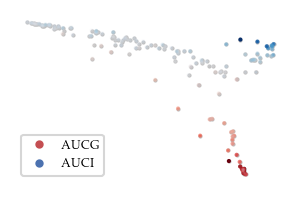

In [10]:
glucose_norm = Normalize(df[" glucose area"].min(), df[" glucose area"].max())
glucose_colors = [
    (*to_rgb(plt.cm.Reds(glucose_norm(x))), glucose_norm(x))
    for x in df[" glucose area"]
]
insulin_norm = Normalize(df[" insulin area"].min(), df[" insulin area"].max())
insulin_colors = [
    (*to_rgb(plt.cm.Blues(insulin_norm(x))), insulin_norm(x))
    for x in df[" insulin area"]
]

sized_fig(0.33)
plt.scatter(*X2.T, s=1, color="silver")
plt.scatter(*X2.T, s=1, c=glucose_colors)
plt.scatter(*X2.T, s=1, c=insulin_colors)
plt.legend(
    loc='lower left',
    handles=[
        Line2D([0], [0], linewidth=0, marker=".", color="r", label="AUCG"),
        Line2D([0], [0], linewidth=0, marker=".", color="b", label="AUCI"),
    ],
)
plt.axis("off")
plt.subplots_adjust(0, 0, 1, 1)
plt.savefig("images/diabetes_umap.pdf", pad_inches=0)
plt.show()

HDBSCAN struggles to detect these branches as distinct clusters. Only with the
*leaf* cluster selection method and low *min samples* values will HDBSCAN detect
small density peaks in the branches.

c:\Users\lucp10736\Micromamba\envs\work\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\lucp10736\Micromamba\envs\work\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


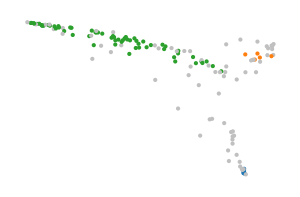

In [11]:
sized_fig(0.33)
c = HDBSCAN(min_cluster_size=5, cluster_selection_method="leaf").fit(X)
cmap = ListedColormap(["silver"] + [plt.cm.tab10.colors[i] for i in range(10)])
plt.scatter(*X2.T, c=c.labels_, s=1, cmap=cmap, vmin=-1, vmax=9)
plt.axis("off")
plt.subplots_adjust(0, 0, 1, 1)
plt.savefig("images/diabetes_hdbscan.pdf", pad_inches=0)
plt.show()

BPSCAN's labels more closely match the projected shape (though, blue and green
should be seen as a single cluster). The algorithm does require tuning: using
low *min samples* values and a *distance fraction* up to 0.5 of the maximum
distance grade.

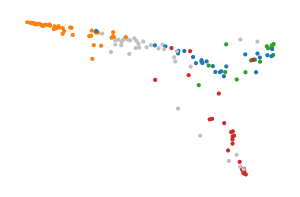

In [29]:
sized_fig(0.33)
c = BPSCAN(min_samples=5, min_cluster_size=15, distance_fraction=0.3).fit(X)
plt.scatter(*X2.T, c=c.labels_, s=1, cmap=cmap, vmin=-1, vmax=9)
plt.axis("off")
plt.subplots_adjust(0, 0, 1, 1)
plt.savefig("images/diabetes_bpscan.pdf", pad_inches=0)
plt.show()

FLASC most accurately describes this dataset, as a single cluster with three
branches. Most of the cluster is fairly central, indicated by the blue cluster.
The other clusters indicate the branches, one of which is also very central and
could be tuned out using a persistence threshold.

c:\Users\lucp10736\Micromamba\envs\work\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\lucp10736\Micromamba\envs\work\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


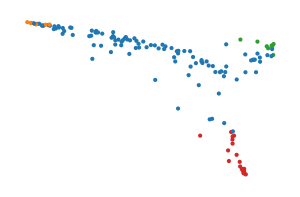

In [30]:
sized_fig(0.33)
c = FLASC(min_samples=5, min_branch_size=5, allow_single_cluster=True).fit(X)
plt.scatter(*X2.T, c=c.labels_, s=1, cmap=cmap, vmin=-1, vmax=9)
plt.axis("off")
plt.subplots_adjust(0, 0, 1, 1)
plt.savefig("images/diabetes_flasc.pdf", pad_inches=0)
plt.show()